## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [1]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msn
from scipy.stats import skew, kurtosis

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Random state seed
rseed = 42

## Load and explore data

In [3]:
# Import the dataset
df = pd.read_csv("Country-data.csv")

In [4]:
# Top 5 rows of the dataset
df.head(5)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [5]:
# Check the shape
df.shape

(167, 10)

In [6]:
# Check datatypes & counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [7]:
# Get descriptive statistics
df.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


In [8]:
# Skewness and Kurtosis
data = df.select_dtypes(include=['float64', 'int64'])
for col in data.columns:
    print(col, ':')
    print(f'\tSkewness: {round(skew(data[col]), 2)}')
    print(f'\tExcess kurtosis: {round(kurtosis(data[col]), 2)} \n\n')
    

child_mort :
	Skewness: 1.44
	Excess kurtosis: 1.68 


exports :
	Skewness: 2.42
	Excess kurtosis: 9.8 


health :
	Skewness: 0.7
	Excess kurtosis: 0.64 


imports :
	Skewness: 1.89
	Excess kurtosis: 6.52 


income :
	Skewness: 2.21
	Excess kurtosis: 6.78 


inflation :
	Skewness: 5.11
	Excess kurtosis: 40.47 


life_expec :
	Skewness: -0.96
	Excess kurtosis: 1.08 


total_fer :
	Skewness: 0.96
	Excess kurtosis: -0.22 


gdpp :
	Skewness: 2.2
	Excess kurtosis: 5.33 




The analysis of the skewness and kurtosis indicated quite a deviation from normal distribution innthe dataset especially in inflation.

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


<Axes: >

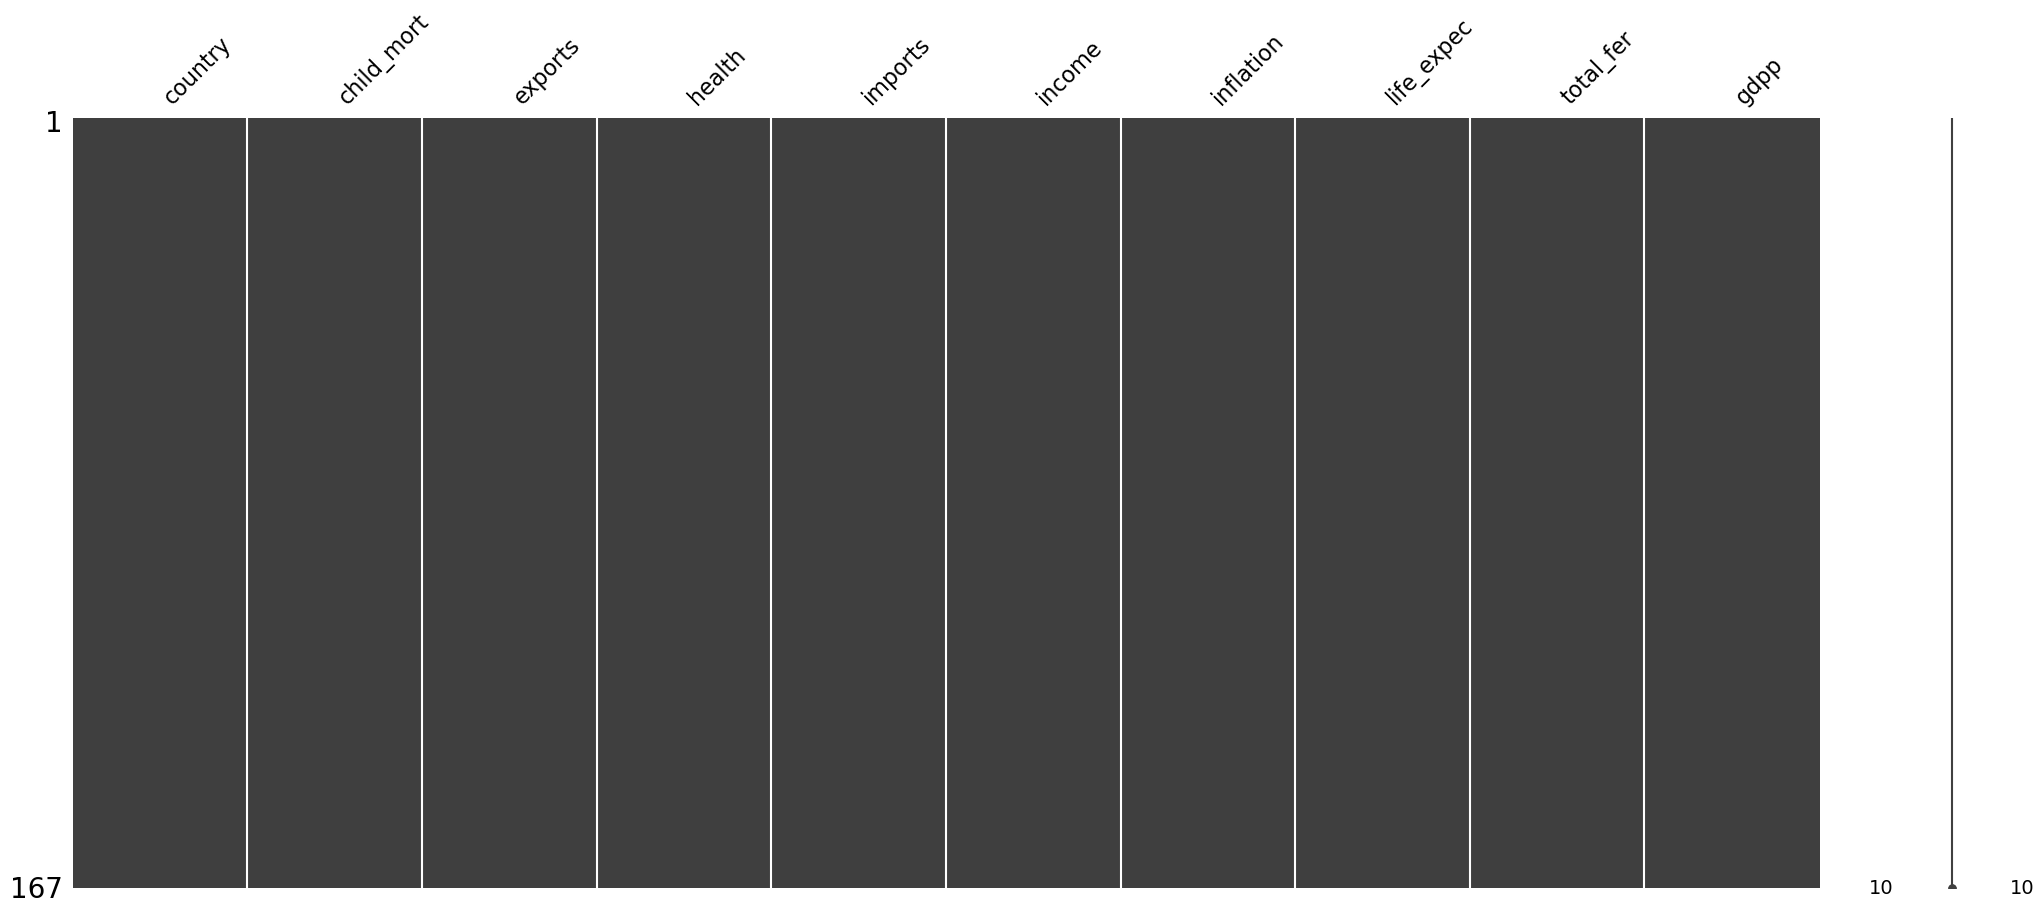

In [9]:
# Identify any missing data
missing = df.isna().sum()
print(missing[:])
msn.matrix(df)

No missing data.

## Preprocessing and Feature Selection

In [10]:
# Drop any non-numeric features (columns)
df.drop(columns=["country"], inplace=True)
df.head(5)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


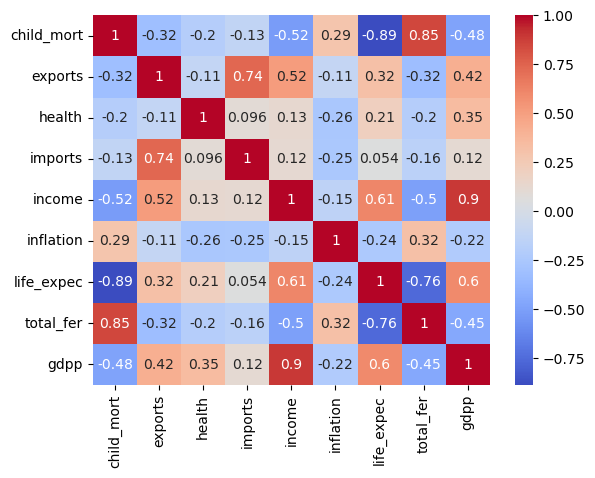

In [11]:
# Create a correlation map of features to explore relationships between features
# Hint: Explore seaborn heatmap
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.show()

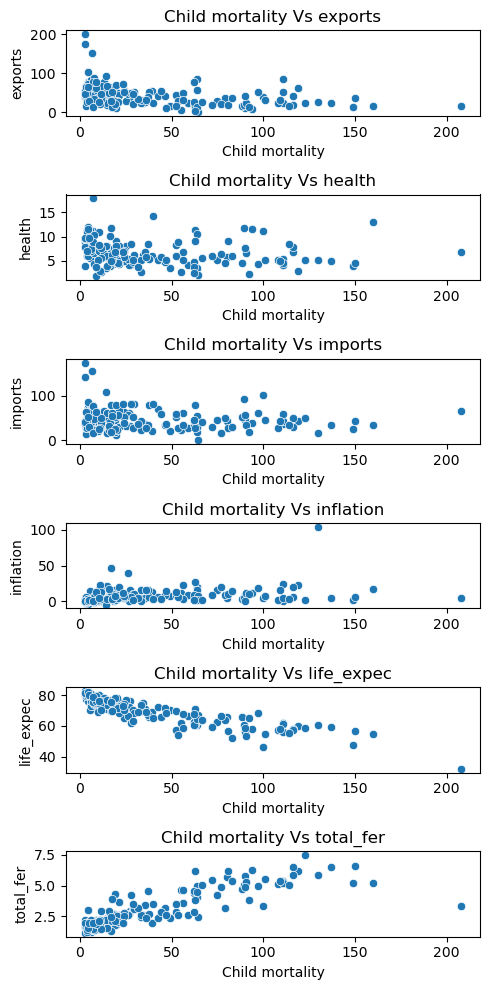

In [12]:
# Explore the continuous independent features against child_mort using scatter plots.
dt = df.select_dtypes(include=['float64'])
col = dt.columns
fig, axes = plt.subplots(nrows=6, figsize=(5,10))
for i in range(1,7):
    sns.scatterplot(x=dt[col[0]], y=dt[col[i]], ax=axes[i-1])
    axes[i-1].set_xlabel("Child mortality")
    axes[i-1].set_ylabel(col[i])
    axes[i-1].set_title(f"Child mortality Vs {col[i]}")
    
plt.tight_layout()
plt.show()

Life expectancy have a strong negative correlation with child mortality, this indicates that as life expectancy increases, child mortality reduces. This shows that life expectancy is highly related to child mortality.

Child mortality can be seen from the scatterplot an heatmap to have a great positive correlation of `.085`. This means that as the birth rate grows, so does the mortality rate in children.

**Note:** The above does not mean causation but just highlighting the relationship according to the available dataset.

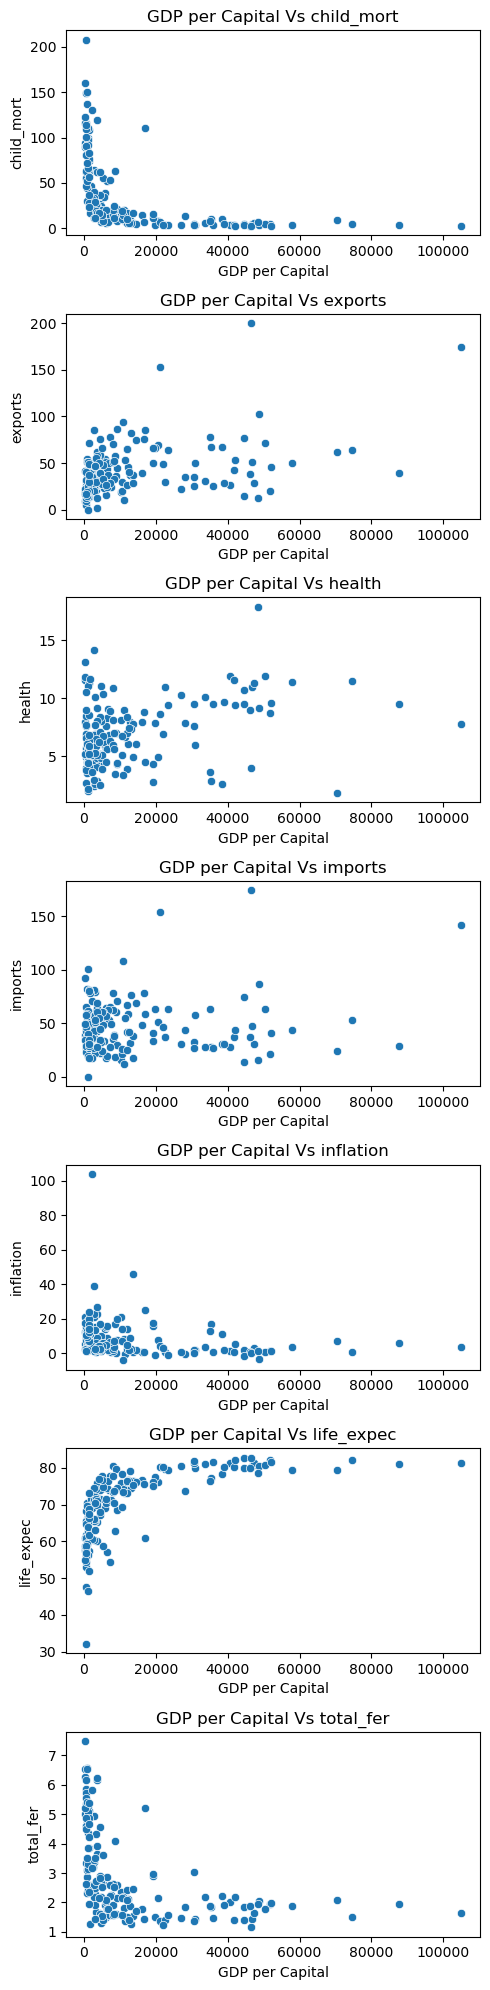

In [13]:
# Explore the continuous independent features against gdpp using scatter plots.
dt = df.drop(columns=["income"])
col = dt.columns
nrows = len(col)-1
fig, axes = plt.subplots(nrows=nrows, figsize=(5,20))
for i in range(nrows):
    sns.scatterplot(x=dt[col[-1]], y=dt[col[i]], ax=axes[i])
    axes[i].set_xlabel("GDP per Capital")
    axes[i].set_ylabel(col[i])
    axes[i].set_title(f"GDP per Capital Vs {col[i]}")
    
plt.tight_layout()
plt.show()

There is no really strong correlation between gdpp and other continuous categorical variables.

/home/eedriz_/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


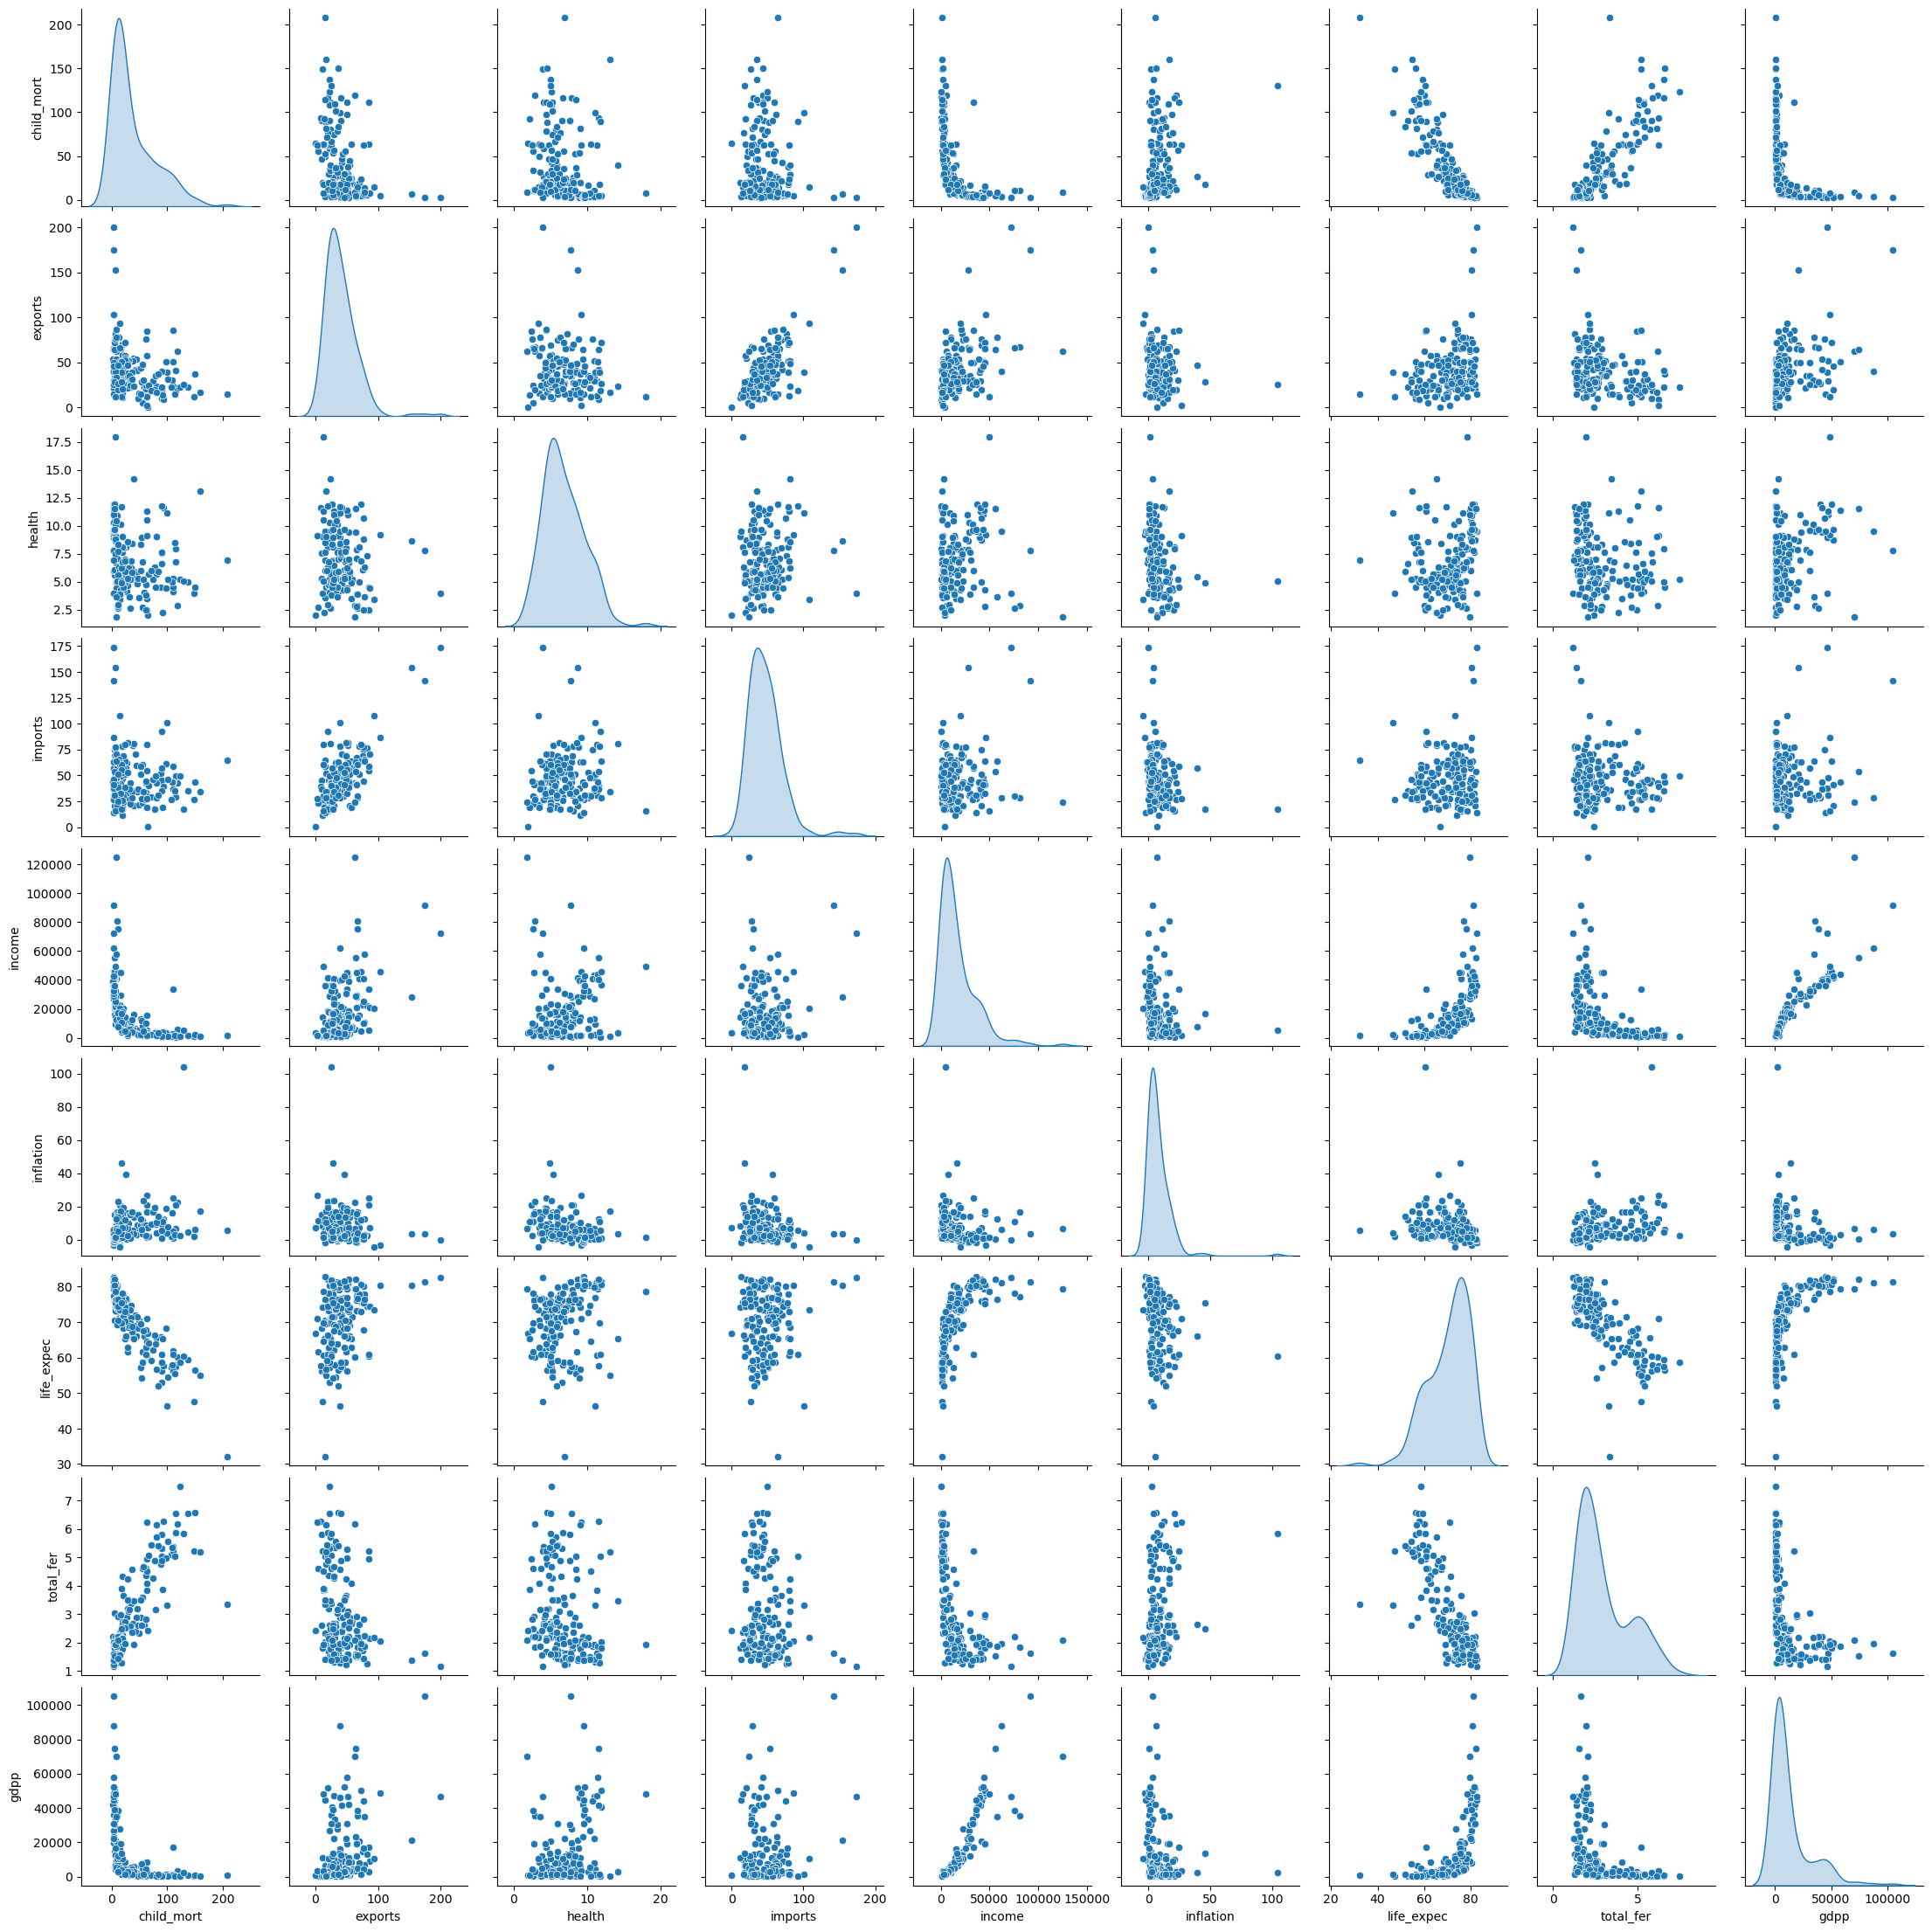

In [14]:
# Create a pair plot
# Hint: Explore seaborn pairplot
sns.pairplot(df, diag_kind='kde')
plt.show()

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

### Scaling the Data

In [15]:
# Normalise the data using MinMaxScaler
# Name the normalised dataframe "df_scaled"
toBeScaled = df.drop(columns=["gdpp"])

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(toBeScaled)
df_scaled = pd.DataFrame(df_scaled, columns=toBeScaled.columns)
df_scaled['gdpp'] = df['gdpp']
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,553
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,4090
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,4460
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,3530
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,12200


## K-Means Clustering

### Selecting K

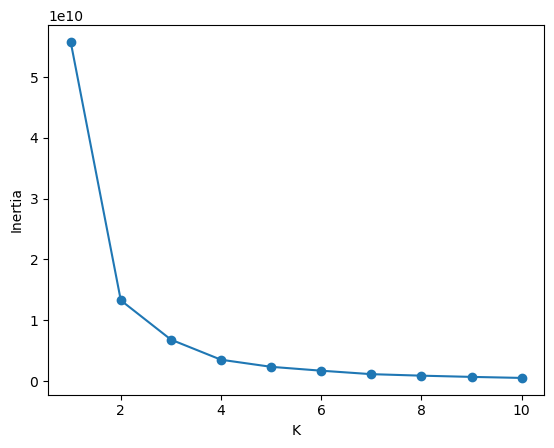

In [16]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

    # Plot elbow curve using scaled dataset
elbow_Kmeans(df_scaled, r=rseed)

The change slope of the elbow graph reduced drastically from `k = 2`. it is safe to say this is where the ellbow starts from.

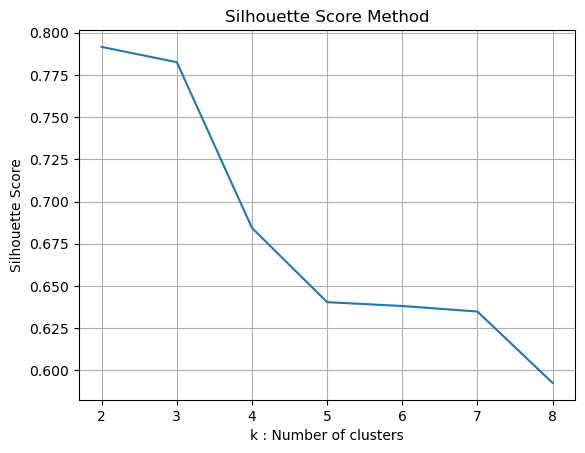

In [17]:
# Silhouette score method
kmax = 8
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

Based on the elbow and silhouette score method choose a value for K.

In conjuction to the elbow plot. The silhouette score is best at `k=2`.

## Fitting a K-Means Model with the selected K value

In [18]:
# Remember to set the random_state to rseed
kMC = KMeans(n_clusters=2, random_state=rseed, max_iter=500)
kMC.fit(df_scaled)

KMeans(max_iter=500, n_clusters=2, random_state=42)

In [19]:
# Count the number of records in each cluster
labels = kMC.labels_
labels = pd.Series(labels)
labels.value_counts()

0    137
1     30
Name: count, dtype: int64

**116** observation of the dataset belong to `cluster 0` and **51** belong to `cluster 1`

In [20]:
# Check model performance with the silhouette coefficient
s_score = silhouette_score(df_scaled, random_state=rseed, labels=labels)
print('Silhouette score: ', round(s_score, 2))

Silhouette score:  0.79


## Predictions

In [21]:
# Add the predicted cluster label column to the original dataframe
df['cluster'] = labels
df.head(5)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0
1,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,0
2,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,0
3,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0
4,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,0


## Visualisation of clusters

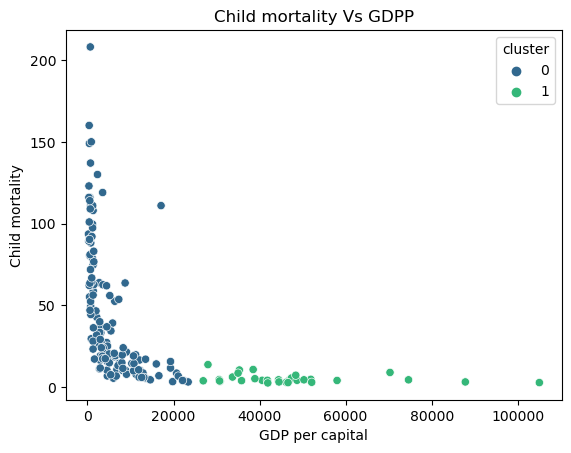

In [22]:
# Visualisation of clusters: child mortality vs gdpp
sns.scatterplot(df, x='gdpp', y='child_mort', hue='cluster', palette='viridis')
plt.xlabel('GDP per capital')
plt.ylabel('Child mortality')
# plt.legend(labels=['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3'])
plt.title('Child mortality Vs GDPP')
plt.show()

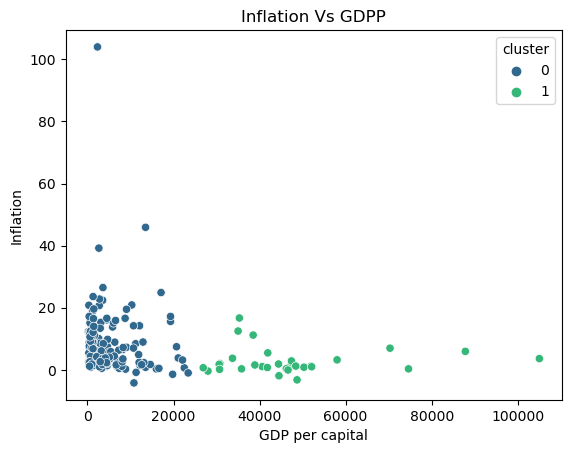

In [23]:
# Visualisation of clusters: inflation vs gdpp

sns.scatterplot(df, x='gdpp', y='inflation', hue='cluster', palette='viridis')
plt.xlabel('GDP per capital')
plt.ylabel('Inflation')
# plt.legend(labels=['cluster 0', 'cluster 1'])
plt.title('Inflation Vs GDPP')
plt.show()

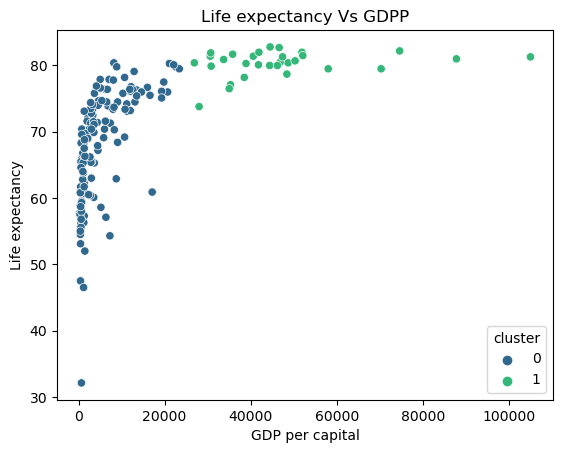

In [24]:
# Visualisation of clusters: life expectancy vs gdpp
sns.scatterplot(df, x='gdpp', y='life_expec', hue='cluster', palette='viridis')
plt.xlabel('GDP per capital')
plt.ylabel('Life expectancy')
# plt.legend(labels=['cluster 0', 'cluster 1'])
plt.title('Life expectancy Vs GDPP')
plt.show()

In [25]:
df.sample(10)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
84,78.9,35.4,4.47,49.3,3980,9.200,63.8,3.15,1140,0
130,7.6,32.9,10.40,47.9,12700,5.880,74.7,1.40,5410,0
94,90.5,22.8,6.59,34.9,1030,12.100,53.1,5.31,459,0
20,6.9,29.7,11.10,51.3,9720,1.400,76.8,1.31,4610,0
36,88.2,16.5,4.51,51.7,1410,3.870,65.9,4.75,769,0
2,27.3,38.4,4.17,31.4,12900,16.100,76.5,2.89,4460,0
163,17.1,28.5,4.91,17.6,16500,45.900,75.4,2.47,13500,0
122,3.9,29.9,11.00,37.4,27200,0.643,79.8,1.39,22500,0
62,35.4,25.8,6.85,36.3,6710,5.140,71.3,3.38,2830,0
80,62.2,20.7,4.75,33.6,2480,2.090,62.8,4.37,967,0


## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


**Answer here:**

* `Cluster 0` is an underdeveloped economy, which is obvious from the prominent low GDP per capita and high inflation and child mortality within the group.
* `Cluster 1` consist of Developed economy, as it can be noted in its GDPP, inflation and chiild mortality.
